In [5]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [ ]:
""";the National Science
Foundation (PHY-1848304), the Office of Naval Research
(N00014-20-1-2695), Department of Energy Quantum DE-SC0024301, and the W. M. Keck Foundation
(Grant No. 995764)."""

In [44]:
N = 3
M = 5

states, _ = enumerate_states(N,M)

V = 1
mu_V_ratio = 0
J_V_ratio = 1.2042332542542542

hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

# need an operator to test, so let's choose this guy
sigma_01 = sigma_ij_operator(0, 1, states, N, M)

# normalizing by M
sigma_01 = sigma_01/M

In [45]:
ground_state_manifold = construct_ground_state_manifold(eigenvalues, eigenvectors)

average_ground_state_expectation_value = 0
for eigenstate in ground_state_manifold:
    average_ground_state_expectation_value += eigenstate.T.conj() @ sigma_01 @ eigenstate
average_ground_state_expectation_value = average_ground_state_expectation_value/len(ground_state_manifold)

In [74]:
N = 5
M = 3
V = -1
mu_V_ratio = 0
J_V_ratios = np.linspace(2, 0, 20)

temperatures = np.logspace(-3, 3, 500)
betas = 1 / temperatures
colors = get_cmap("gist_rainbow", len(J_V_ratios))

states, _ = enumerate_states(N, M)

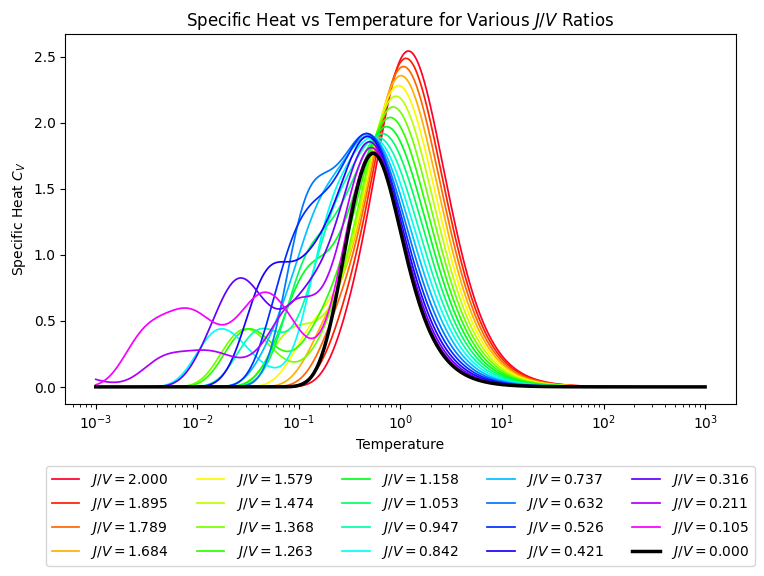

In [76]:
N = 5
M = 3
V = 1
mu_V_ratio = 0
J_V_ratios = np.linspace(2, 0, 20)

temperatures = np.logspace(-3, 3, 500)
betas = 1 / temperatures
colors = get_cmap("gist_rainbow", len(J_V_ratios))

states, _ = enumerate_states(N, M)

ig, ax = plt.subplots(figsize=(8,6))
for i, J_V_ratio in enumerate(J_V_ratios):
    Cv_values = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        Cv = calculate_specific_heat(beta, eigenvalues) 
        Cv_values.append(Cv)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, Cv_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.3f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Specific Heat $C_V$")
ax.set_title("Specific Heat vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

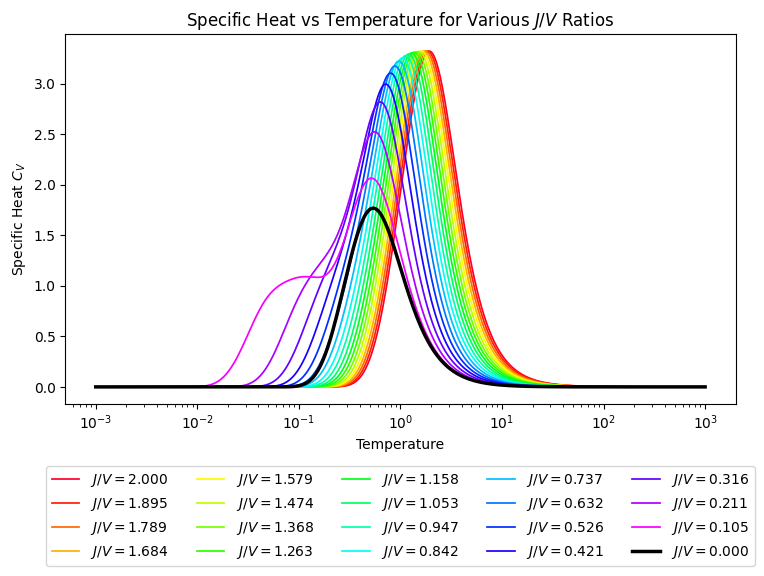

In [77]:
N = 5
M = 3
V = -1
mu_V_ratio = 0
J_V_ratios = np.linspace(2, 0, 20)

temperatures = np.logspace(-3, 3, 500)
betas = 1 / temperatures
colors = get_cmap("gist_rainbow", len(J_V_ratios))

states, _ = enumerate_states(N, M)

fig, ax = plt.subplots(figsize=(8,6))
for i, J_V_ratio in enumerate(J_V_ratios):
    Cv_values = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        Cv = calculate_specific_heat(beta, eigenvalues) 
        Cv_values.append(Cv)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, Cv_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.3f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Specific Heat $C_V$")
ax.set_title("Specific Heat vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

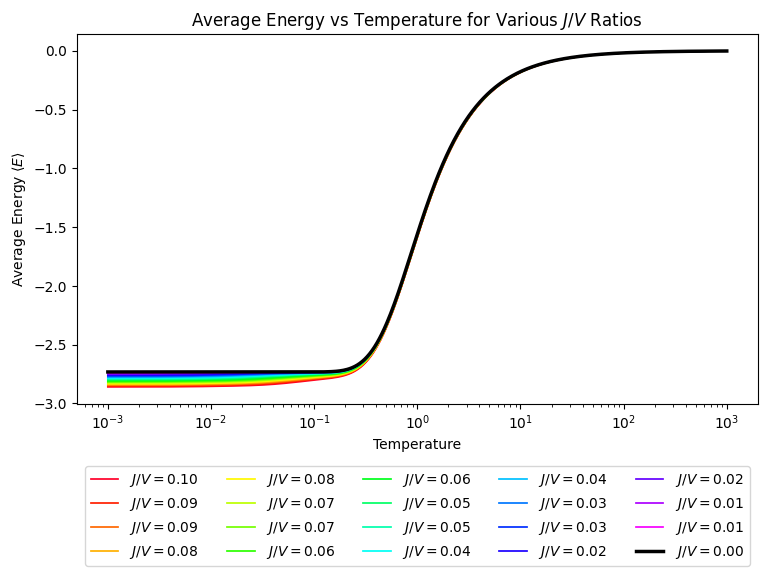

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
for i, J_V_ratio in enumerate(J_V_ratios):
    average_energies = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        average_energy = calculate_average_energy(beta, eigenvalues)  
        average_energies.append(average_energy)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, average_energies, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.2f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Average Energy $\langle E \\rangle$")
ax.set_title("Average Energy vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

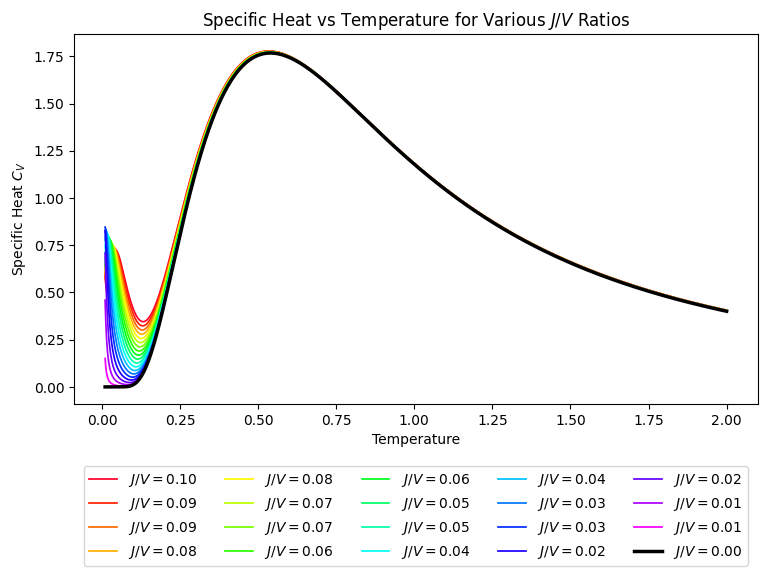

In [49]:
fig, ax = plt.subplots(figsize=(8,6))

temperatures = np.linspace(0.01,2,1000)
betas = 1/temperatures
for i, J_V_ratio in enumerate(J_V_ratios):
    Cv_values = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        Cv = calculate_specific_heat(beta, eigenvalues)
        Cv_values.append(Cv)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, Cv_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.2f}$")


ax.set_xlabel("Temperature")
ax.set_ylabel("Specific Heat $C_V$")
ax.set_title("Specific Heat vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

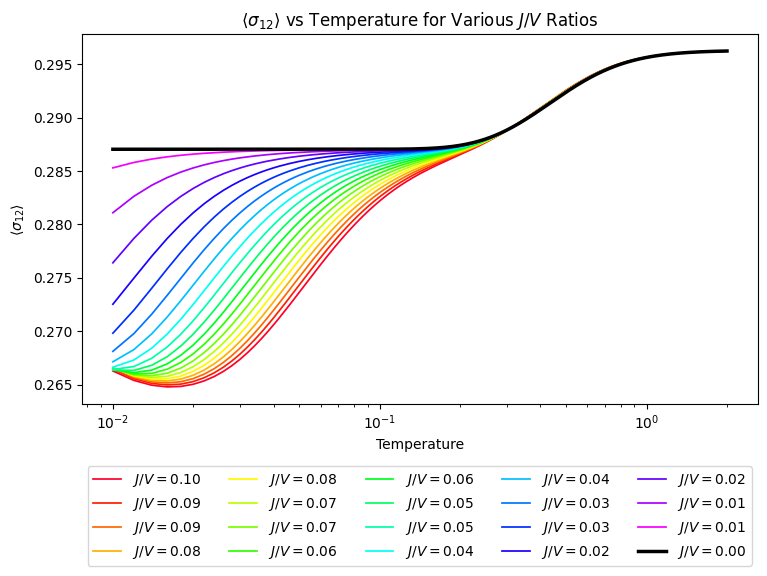

In [50]:
sigma_12 = sigma_ij_operator(1, 2, states, N, M)
sigma_12 = sigma_12/M

temperatures = np.linspace(0.01,2,1000)
fig, ax = plt.subplots(figsize=(8, 6))
for i, J_V_ratio in enumerate(J_V_ratios):
    expectation_values = []
    
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        expectation_value = calculate_finite_temperature_expectation_value(sigma_12, beta, eigenvalues, eigenvectors)  
        expectation_values.append(expectation_value)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, expectation_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.2f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("$\langle \sigma_{12} \\rangle$")
ax.set_title("$\langle \sigma_{12} \\rangle$ vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

In [ ]:
"""# Parameters
N = 3
M = 5
V = 1
mu_V_ratio = 0

# Get states
states, _ = enumerate_states(N, M)

# Operators
sigma_01 = sigma_ij_operator(0, 1, states, N, M) / M

# Sweep ranges
J_V_ratios = np.linspace(0, 2, 100)
temperatures = np.logspace(-3, 3, 100)

# Prepare expectation value map
expectation_map = np.zeros((len(temperatures), len(J_V_ratios)))

# Compute expectation values
for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature

        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        expectation_value = calculate_finite_temperature_expectation_value(
            sigma_01,
            beta,
            energy_eigenvalues=eigenvalues,
            energy_eigenstates=eigenvectors
        )

        expectation_map[i, j] = np.real(expectation_value)  # Ensure real value

# Plot colormap
plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, expectation_map, shading='auto', cmap='plasma')
plt.yscale('log')

plt.colorbar(c, label=r'$\langle \sigma_{01} \rangle$')
plt.xlabel(r'$J/V$')
plt.ylabel('Temperature')
plt.title(r'Finite-T Expectation Value of $\sigma_{01}$')

plt.tight_layout()
plt.show()
"""

"# Parameters\nN = 3\nM = 5\nV = 1\nmu_V_ratio = 0\n\n# Get states\nstates, _ = enumerate_states(N, M)\n\n# Operators\nsigma_01 = sigma_ij_operator(0, 1, states, N, M) / M\n\n# Sweep ranges\nJ_V_ratios = np.linspace(0, 2, 100)\ntemperatures = np.logspace(-3, 3, 100)\n\n# Prepare expectation value map\nexpectation_map = np.zeros((len(temperatures), len(J_V_ratios)))\n\n# Compute expectation values\nfor j, J_V_ratio in enumerate(J_V_ratios):\n    for i, temperature in enumerate(temperatures):\n        beta = 1 / temperature\n\n        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)\n        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)\n\n        expectation_value = calculate_finite_temperature_expectation_value(\n            sigma_01,\n            beta,\n            energy_eigenvalues=eigenvalues,\n            energy_eigenstates=eigenvectors\n        )\n\n        expectation_map[i, j] = np.real(expectation_value)  # Ensure real value\n\n# Plot c

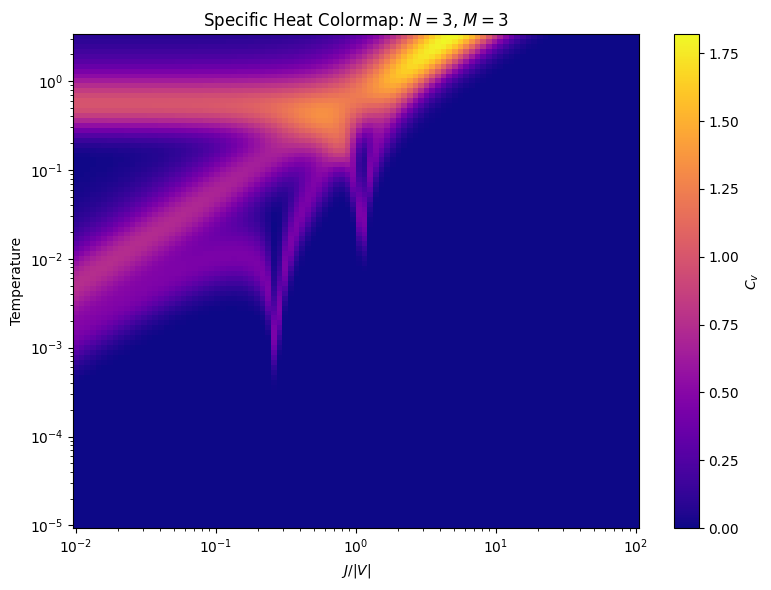

In [79]:
N = 3
M = 3
V = 1

J_V_ratios = np.logspace(-2, 2, 100)
temperatures = np.logspace(-5, 0.5, 100)

cv_grid = np.zeros((len(temperatures), len(J_V_ratios)))

for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature
        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
        specific_heat = calculate_specific_heat(beta, eigenvalues)
        cv_grid[i, j] = specific_heat

plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, cv_grid, shading='auto', cmap='plasma')
plt.xscale("log")
plt.yscale('log')

plt.colorbar(c, label='$C_v$')
plt.xlabel('$J/|V|$')
plt.ylabel('Temperature')
plt.title(f"Specific Heat Colormap: $N={N}$, $M={M}$")

plt.tight_layout()
plt.show()

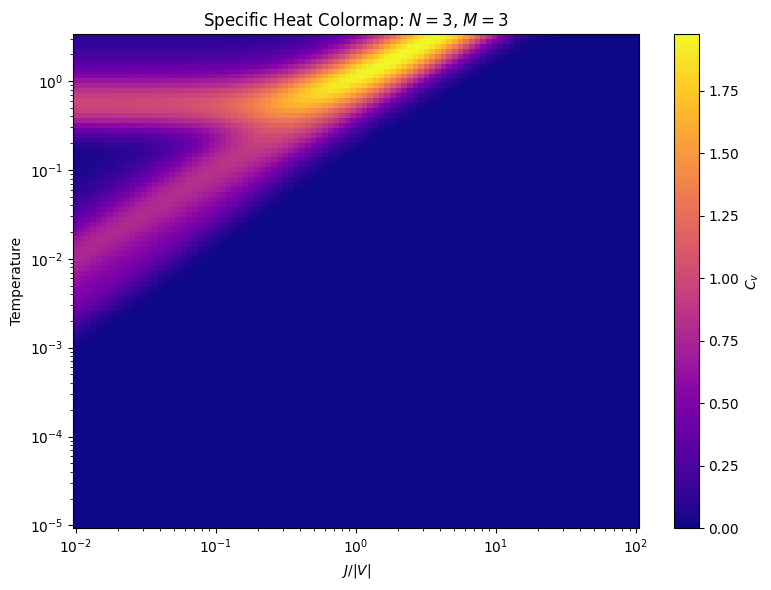

In [78]:
N = 3
M = 3
V = -1

J_V_ratios = np.logspace(-2, 2, 100)
temperatures = np.logspace(-5, 0.5, 100)

cv_grid = np.zeros((len(temperatures), len(J_V_ratios)))

for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature
        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
        specific_heat = calculate_specific_heat(beta, eigenvalues)
        cv_grid[i, j] = specific_heat

plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, cv_grid, shading='auto', cmap='plasma')
plt.xscale("log")
plt.yscale('log')

plt.colorbar(c, label='$C_v$')
plt.xlabel('$J/|V|$')
plt.ylabel('Temperature')
plt.title(f"Specific Heat Colormap: $N={N}$, $M={M}$")

plt.tight_layout()
plt.show()

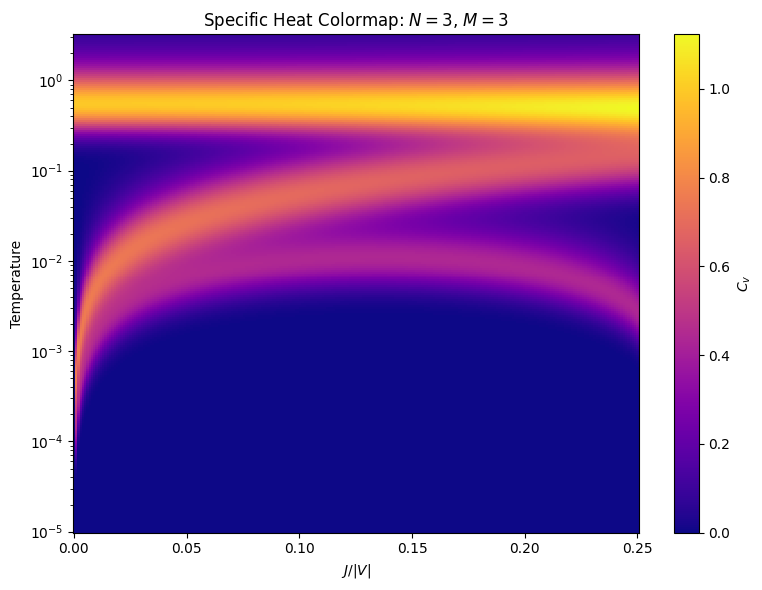

In [37]:
N = 3
M = 3
V = 1

J_V_ratios = np.linspace(0.25, 0, 250)
temperatures = np.logspace(-5, 0.5, 250)

cv_grid = np.zeros((len(temperatures), len(J_V_ratios)))

for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature
        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
        specific_heat = calculate_specific_heat(beta, eigenvalues)
        cv_grid[i, j] = specific_heat

plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, cv_grid, shading='auto', cmap='plasma')
plt.yscale('log')

plt.colorbar(c, label='$C_v$')
plt.xlabel('$J/|V|$')
plt.ylabel('Temperature')
plt.title(f"Specific Heat Colormap: $N={N}$, $M={M}$")

plt.tight_layout()
plt.show()

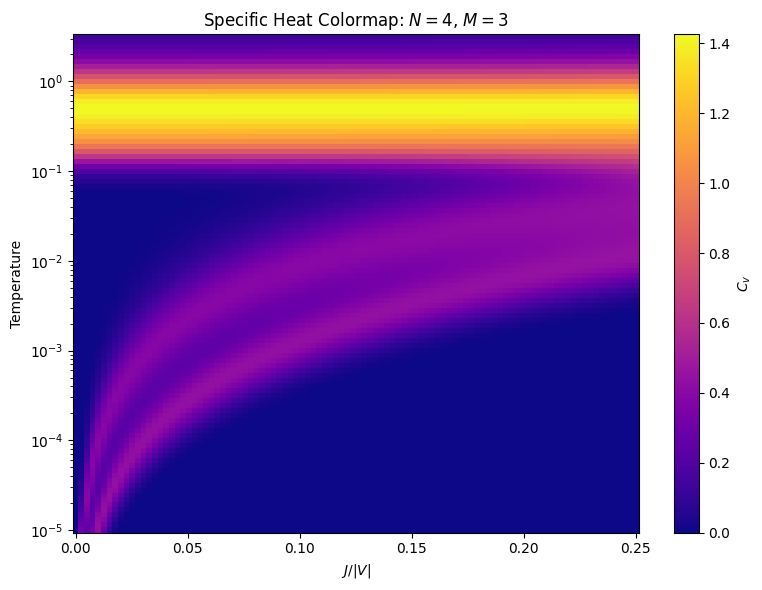

In [39]:
N = 4
M = 3
V = 1

J_V_ratios = np.linspace(0.25, 0, 100)
temperatures = np.logspace(-5, 0.5, 100)

cv_grid = np.zeros((len(temperatures), len(J_V_ratios)))

for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature
        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
        specific_heat = calculate_specific_heat(beta, eigenvalues)
        cv_grid[i, j] = specific_heat

plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, cv_grid, shading='auto', cmap='plasma')
plt.yscale('log')

plt.colorbar(c, label='$C_v$')
plt.xlabel('$J/|V|$')
plt.ylabel('Temperature')
plt.title(f"Specific Heat Colormap: $N={N}$, $M={M}$")

plt.tight_layout()
plt.show()

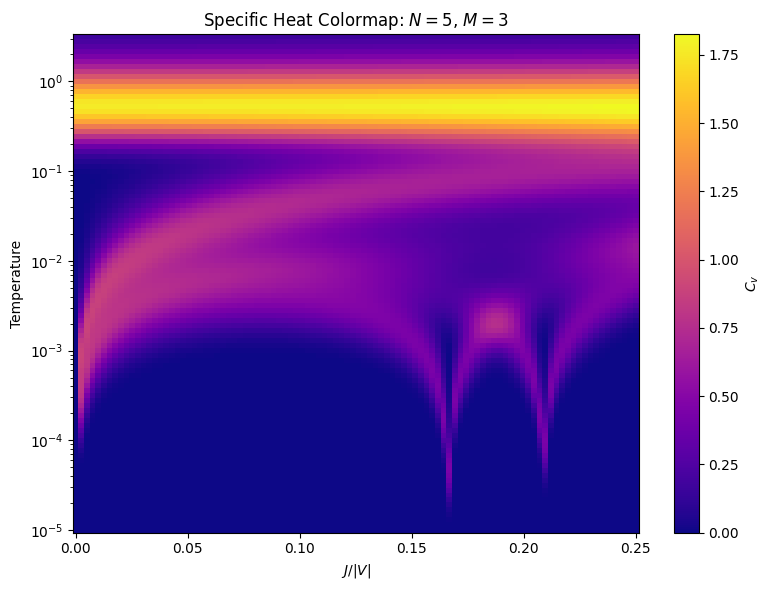

In [40]:
N = 5
M = 3
V = 1

J_V_ratios = np.linspace(0.25, 0, 100)
temperatures = np.logspace(-5, 0.5, 100)

cv_grid = np.zeros((len(temperatures), len(J_V_ratios)))

for j, J_V_ratio in enumerate(J_V_ratios):
    for i, temperature in enumerate(temperatures):
        beta = 1 / temperature
        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
        specific_heat = calculate_specific_heat(beta, eigenvalues)
        cv_grid[i, j] = specific_heat

plt.figure(figsize=(8, 6))

J_grid, T_grid = np.meshgrid(J_V_ratios, temperatures)

c = plt.pcolormesh(J_grid, T_grid, cv_grid, shading='auto', cmap='plasma')
plt.yscale('log')

plt.colorbar(c, label='$C_v$')
plt.xlabel('$J/|V|$')
plt.ylabel('Temperature')
plt.title(f"Specific Heat Colormap: $N={N}$, $M={M}$")

plt.tight_layout()
plt.show()

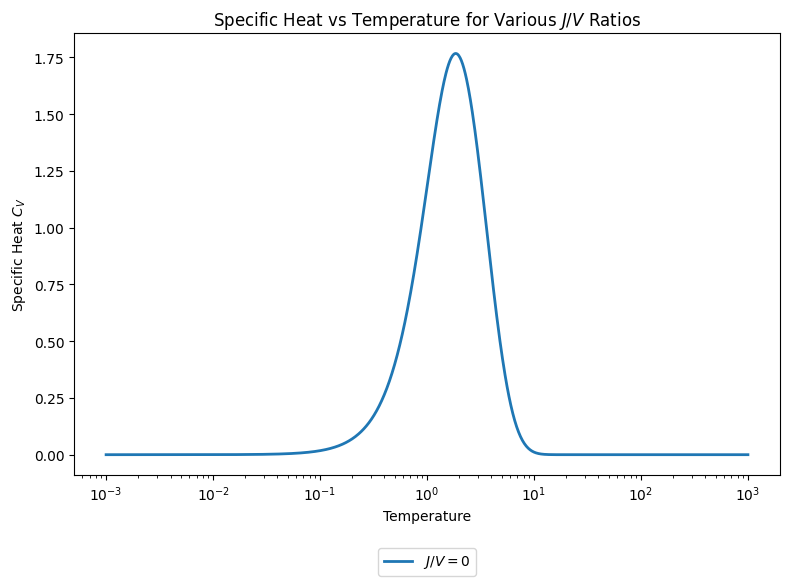

Fitted ε ≈ 1.3709
Fitted prefactor (2kBε²) ≈ 9.4787


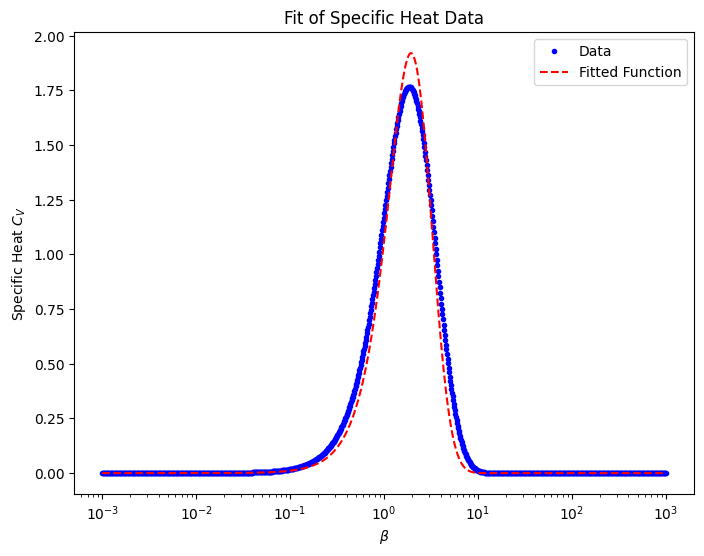

In [ ]:
N = 5
M = 3
V = 1

mu_V_ratio = 0
J_V_ratio = 0

betas = np.logspace(-3,3,1000)

colors = get_cmap("gist_rainbow", len(J_V_ratios))

Cv_values = []
hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
for beta in betas:
    Cv = calculate_specific_heat(beta, eigenvalues) 
    Cv_values.append(Cv)
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(betas, Cv_values, linewidth = 2, label=f"$J/V = 0$")
ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Specific Heat $C_V$")
ax.set_title("Specific Heat vs Temperature for Various $J/V$ Ratios")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()


Fitted ε₁ ≈ 1.3709, ε₂ ≈ 1.3710


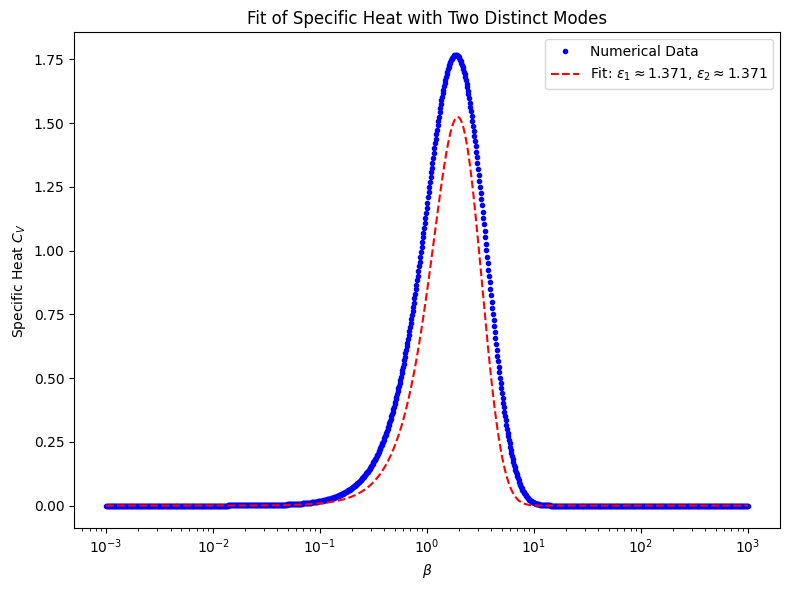

In [45]:
def model_func(beta, epsilon1, epsilon2):
    term1 = epsilon1**2 * np.exp(-beta * epsilon1) / (1 + 2 * np.exp(-beta * epsilon1))**2
    term2 = epsilon2**2 * np.exp(-beta * epsilon2) / (1 + 2 * np.exp(-beta * epsilon2))**2
    return 2 * beta**2 * (term1 + term2)

from scipy.optimize import curve_fit

# Assume betas and Cv_values are already computed from your model
xdata = np.array(betas)
ydata = np.array(Cv_values)

# Fit the model
popt, pcov = curve_fit(model_func, xdata, ydata, p0=[1.0, 0.5])  # Initial guesses for ε₁, ε₂
epsilon1, epsilon2 = popt

print(f"Fitted ε₁ ≈ {epsilon1:.4f}, ε₂ ≈ {epsilon2:.4f}")

# Compute fitted curve
fitted_y = model_func(xdata, epsilon1, epsilon2)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(xdata, ydata, ".b", label="Numerical Data")
plt.plot(xdata, fitted_y, "r--", label=fr"Fit: $\varepsilon_1 \approx {epsilon1:.3f}$, $\varepsilon_2 \approx {epsilon2:.3f}$")
plt.xscale("log")
plt.xlabel(r"$\beta$")
plt.ylabel(r"Specific Heat $C_V$")
plt.title("Fit of Specific Heat with Two Distinct Modes")
plt.legend()
plt.tight_layout()
plt.show()
